In [ ]:
import warnings
import math
warnings.filterwarnings("ignore")

In [ ]:
import os
import tarfile
import urllib.request

# Define the URL and download path
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"
download_path = "VOCtrainval_06-Nov-2007.tar"
extract_path = "VOC2007"

# Download the dataset
if not os.path.exists(download_path):
    print("Downloading Pascal VOC dataset...")
    urllib.request.urlretrieve(url, download_path)
    print("Download complete!")

# Extract the dataset
if not os.path.exists(extract_path):
    print("Extracting dataset...")
    with tarfile.open(download_path, "r") as tar:
        tar.extractall(path=extract_path)
    print("Extraction complete!")


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import xml.etree.ElementTree as ET
import numpy as np

# Define the class names for Pascal VOC
VOC_CLASSES = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
    'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
    'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
]

class VOCDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC2007', 'JPEGImages')
        self.anno_dir = os.path.join(root_dir, 'VOCdevkit', 'VOC2007', 'Annotations')

        # Get image IDs from the split
        split_file = os.path.join(root_dir, 'VOCdevkit', 'VOC2007', 'ImageSets', 'Main', f'{split}.txt')
        with open(split_file, 'r') as f:
            self.ids = [line.strip() for line in f.readlines()]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path = os.path.join(self.image_dir, f'{img_id}.jpg')
        anno_path = os.path.join(self.anno_dir, f'{img_id}.xml')

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Parse annotation
        tree = ET.parse(anno_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = VOC_CLASSES.index(obj.find('name').text)
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transform:
            image = self.transform(image)

        return image, target

# Define transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = VOCDataset(extract_path, split='train', transform=train_transform)
val_dataset = VOCDataset(extract_path, split='val', transform=val_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2, collate_fn=lambda x: x)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2, collate_fn=lambda x: x)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")


Training dataset size: 2501
Validation dataset size: 2510


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class DETR_ResNet50(nn.Module):
    def __init__(self, num_classes, num_queries=100, hidden_dim=512):
        super().__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        # ResNet50 backbone
        backbone = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove avg pool and FC

        # Projection from backbone to transformer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # Transformer encoder
        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=8, dim_feedforward=2048, dropout=0.1,batch_first = True)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=6)

        # Transformer decoder
        decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=8, dim_feedforward=2048, dropout=0.1,batch_first=True)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=6)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_dim)

        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)

        # Output heads
        self.class_head = nn.Linear(hidden_dim, num_classes + 1)  # +1 for background
        self.bbox_head = nn.Linear(hidden_dim, 4)  # (x, y, w, h)

    def forward(self, x):
        # Extract features from backbone
        features = self.backbone(x)  # [batch_size, 2048, H/32, W/32]
        features = self.conv(features)  # [batch_size, hidden_dim, H/32, W/32]

        # Flatten spatial dimensions and transpose
        batch_size, c, h, w = features.shape
        features = features.flatten(2).permute(0, 2, 1)  # [H*W, batch_size, hidden_dim]

        # Add positional encoding
        features = self.pos_encoder(features)

        # Transformer encoder
        memory = self.transformer_encoder(features)  # [H*W, batch_size, hidden_dim]

        # Prepare queries
        queries = self.query_embed.weight.unsqueeze(0).repeat(batch_size, 1, 1)  # [num_queries, batch_size, hidden_dim]

        # Transformer decoder
        tgt = torch.zeros_like(queries)
        output = self.transformer_decoder(tgt, memory)  # [num_queries, batch_size, hidden_dim]

        # Output heads
        output = output.transpose(0, 1)  # [batch_size, num_queries, hidden_dim]
        class_logits = self.class_head(output)  # [batch_size, num_queries, num_classes+1]
        bbox_pred = self.bbox_head(output).sigmoid()  # [batch_size, num_queries, 4]

        return {'pred_logits': class_logits, 'pred_boxes': bbox_pred}

# Initialize model
detr_resnet50 = DETR_ResNet50(num_classes=len(VOC_CLASSES))
print("DETR with ResNet-50 backbone initialized")


DETR with ResNet-50 backbone initialized


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class MLP(nn.Module):
    """ Very simple multi-layer perceptron (also called FFN) """
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        self.num_layers = num_layers
        h = [hidden_dim] * (num_layers - 1)
        self.layers = nn.ModuleList(nn.Linear(n, k) for n, k in zip([input_dim] + h, h + [output_dim]))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = F.relu(layer(x)) if i < self.num_layers - 1 else layer(x)
        return x

class DETR_ViT(nn.Module):
    def __init__(self, backbone_type='resnet', num_classes=21, num_queries=100,
                hidden_dim=256, nheads=8, num_encoder_layers=6, num_decoder_layers=6):
        super(DETR_ViT, self).__init__()

        self.num_queries = num_queries
        self.num_classes = num_classes
        self.hidden_dim = hidden_dim

        # Backbone
        if backbone_type == 'resnet':
            backbone = models.resnet50(pretrained=True)
            self.backbone = nn.Sequential(*list(backbone.children())[:-2])  # Remove avg pool and FC
            self.input_proj = nn.Conv2d(2048, hidden_dim, kernel_size=1)
        elif backbone_type == 'vit':
            # Use Vision Transformer as backbone
            vit = models.vit_b_16(pretrained=True)
            self.backbone = vit
            self.backbone.heads = nn.Identity()  # Remove classifier head
            self.input_proj = nn.Linear(768, hidden_dim)  # Project ViT features to hidden_dim
        else:
            raise ValueError(f"Unsupported backbone type: {backbone_type}")

        self.backbone_type = backbone_type

        # Transformer
        encoder_layer = TransformerEncoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim*4,
                                            dropout=0.1, activation='relu')
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        decoder_layer = TransformerDecoderLayer(d_model=hidden_dim, nhead=nheads, dim_feedforward=hidden_dim*4,
                                            dropout=0.1, activation='relu')
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout=0.1)

        # Output heads
        self.class_embed = nn.Linear(hidden_dim, num_classes)
        self.bbox_embed = MLP(hidden_dim, hidden_dim, 4, 3)  # Center x, y, width, height

        # Object queries
        self.query_embed = nn.Embedding(num_queries, hidden_dim)

    def forward(self, x):
        bs = x.shape[0]

        # Extract features with backbone
        if self.backbone_type == 'resnet':
            features = self.backbone(x)
            h = self.input_proj(features)

            # Flatten spatial dimensions
            h = h.flatten(2).permute(2, 0, 1)  # (HW, BS, C)
        else:  # ViT
            features = self.backbone(x)
            h = self.input_proj(features)
            h = h.unsqueeze(0)  # Add spatial dimension for encoder (1, BS, C)

        # Add positional encoding
        h = self.pos_encoder(h)

        # Pass through transformer encoder
        memory = self.transformer_encoder(h)

        # Prepare queries
        query_embed = self.query_embed.weight.unsqueeze(1).repeat(1, bs, 1)  # (num_queries, BS, hidden_dim)

        # Decode
        tgt = torch.zeros_like(query_embed)
        hs = self.transformer_decoder(tgt, memory)  # (num_queries, BS, hidden_dim)

        # Predict class and bbox
        outputs_class = self.class_embed(hs)  # (num_queries, BS, num_classes)
        outputs_coord = self.bbox_embed(hs).sigmoid()  # (num_queries, BS, 4) - Normalized to [0, 1]

        # Reshape outputs
        outputs_class = outputs_class.transpose(0, 1)  # (BS, num_queries, num_classes)
        outputs_coord = outputs_coord.transpose(0, 1)  # (BS, num_queries, 4)

        return {'pred_logits': outputs_class, 'pred_boxes': outputs_coord}

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter
from torchvision.ops import generalized_box_iou
from scipy.optimize import linear_sum_assignment
from torch.optim.lr_scheduler import LambdaLR


class HungarianMatcher(nn.Module):
    def __init__(self, cost_class=1, cost_bbox=5, cost_giou=2):  # ↓ reduced bbox cost
        super().__init__()
        self.cost_class = cost_class
        self.cost_bbox = cost_bbox
        self.cost_giou = cost_giou

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]

        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
        out_bbox = outputs["pred_boxes"].flatten(0, 1)

        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_bbox = torch.cat([v["boxes"] for v in targets])

        cost_class = -out_prob[:, tgt_ids]
        cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1)
        cost_giou = -generalized_box_iou(out_bbox, tgt_bbox)

        C = self.cost_class * cost_class + self.cost_bbox * cost_bbox + self.cost_giou * cost_giou
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["boxes"]) for v in targets]
        indices = []
        start_idx = 0
        for i, size in enumerate(sizes):
            cost = C[i, :, start_idx:start_idx + size]
            idx_i, idx_j = linear_sum_assignment(cost)
            indices.append((torch.as_tensor(idx_i, dtype=torch.int64),
                            torch.as_tensor(idx_j, dtype=torch.int64)))
            start_idx += size
        return indices


def train_one_epoch(model, data_loader, optimizer, device, epoch, writer, scheduler=None):
    model.train()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0
    total_giou_loss = 0

    matcher = HungarianMatcher()

    start_time = time.time()
    for i, batch in enumerate(data_loader):
        images = [img.to(device) for img, _ in batch]
        targets = [{k: v.to(device) for k, v in t.items()} for _, t in batch]

        # Normalize boxes to [0, 1] based on image size
        for img, target in zip(images, targets):
            h, w = img.shape[-2:]
            target['boxes'][:, [0, 2]] /= w
            target['boxes'][:, [1, 3]] /= h

        outputs = model(torch.stack(images))

        indices = matcher(outputs, targets)

        class_loss = 0
        bbox_loss = 0
        giou_loss = 0

        for idx, (pred_idx, tgt_idx) in enumerate(indices):
            pred_logits = outputs['pred_logits'][idx, pred_idx]
            target_classes = targets[idx]['labels'][tgt_idx]
            class_loss += F.cross_entropy(pred_logits, target_classes)

            pred_boxes = outputs['pred_boxes'][idx, pred_idx]
            target_boxes = targets[idx]['boxes'][tgt_idx]
            bbox_loss += F.smooth_l1_loss(pred_boxes, target_boxes, beta=1.0)

            giou = generalized_box_iou(pred_boxes, target_boxes)
            giou_val = giou.diag().clamp(min=-1.0, max=1.0).mean()
            giou_loss += (1 - giou_val).clamp(min=0)


        # Weighting losses
        loss = 1 * class_loss + 1*bbox_loss +  1*giou_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()
        total_giou_loss += giou_loss.item()

        if i % 313 == 0:
            print(f"Epoch {epoch}, Batch {i}/{len(data_loader)}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / len(data_loader)
    avg_class_loss = total_class_loss / len(data_loader)
    avg_bbox_loss = total_bbox_loss / len(data_loader)
    avg_giou_loss = total_giou_loss / len(data_loader)

    writer.add_scalar('Loss/train', avg_loss, epoch)
    writer.add_scalar('Loss/class', avg_class_loss, epoch)
    writer.add_scalar('Loss/bbox', avg_bbox_loss, epoch)
    writer.add_scalar('Loss/giou', avg_giou_loss, epoch)

    print(f"Epoch {epoch} completed in {time.time() - start_time:.2f}s, Avg Loss: {avg_loss:.4f}")

    return avg_loss, avg_class_loss, avg_bbox_loss, avg_giou_loss

In [ ]:
def validate(model, val_loader, device, epoch, writer):
    model.eval()
    total_loss = 0
    total_class_loss = 0
    total_bbox_loss = 0
    total_giou_loss = 0
    matcher = HungarianMatcher()

    with torch.no_grad():
        for batch in val_loader:
            images = [img.to(device) for img, _ in batch]
            targets = [{k: v.to(device) for k, v in t.items()} for _, t in batch]

            for img, target in zip(images, targets):
                h, w = img.shape[-2:]
                target['boxes'][:, [0, 2]] /= w
                target['boxes'][:, [1, 3]] /= h

            outputs = model(torch.stack(images))
            indices = matcher(outputs, targets)

            class_loss = 0
            bbox_loss = 0
            giou_loss = 0

            for idx, (pred_idx, tgt_idx) in enumerate(indices):
                pred_logits = outputs['pred_logits'][idx, pred_idx]
                target_classes = targets[idx]['labels'][tgt_idx]
                class_loss += F.cross_entropy(pred_logits, target_classes)

                pred_boxes = outputs['pred_boxes'][idx, pred_idx]
                target_boxes = targets[idx]['boxes'][tgt_idx]
                bbox_loss += F.smooth_l1_loss(pred_boxes, target_boxes, beta=1.0)

                giou = generalized_box_iou(pred_boxes, target_boxes)
                giou_loss_batch = 1 - giou.diag().clamp(min=-1.0, max=1.0).mean()
                giou_loss += giou_loss_batch.clamp(min=0)

            loss = 1 * class_loss + 1*bbox_loss +  1*giou_loss

            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()
            total_giou_loss += giou_loss.item()

    avg_loss = total_loss / len(val_loader)
    avg_class_loss = total_class_loss / len(val_loader)
    avg_bbox_loss = total_bbox_loss / len(val_loader)
    avg_giou_loss = total_giou_loss / len(val_loader)

    writer.add_scalar('Loss/val', avg_loss, epoch)
    writer.add_scalar('Loss/val_class', avg_class_loss, epoch)
    writer.add_scalar('Loss/val_bbox', avg_bbox_loss, epoch)
    writer.add_scalar('Loss/val_giou', avg_giou_loss, epoch)

    print(f"Validation - Epoch {epoch}, Avg Loss: {avg_loss:.4f}, Class: {avg_class_loss:.4f}, "
          f"BBox: {avg_bbox_loss:.4f}, GIoU: {avg_giou_loss:.4f}")

    return avg_loss, avg_class_loss, avg_bbox_loss, avg_giou_loss


def get_warmup_scheduler(optimizer, warmup_steps):
    def lr_lambda(step):
        if step < warmup_steps:
            return step / max(1, warmup_steps)
        return 1.0
    return LambdaLR(optimizer, lr_lambda)


def train_model(model, train_loader, val_loader, device, num_epochs=10):
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    writer = SummaryWriter(f'runs/{model.__class__.__name__}')
    scheduler = get_warmup_scheduler(optimizer, warmup_steps=1)

    model.to(device)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss, *_ = train_one_epoch(model, train_loader, optimizer, device, epoch, writer, scheduler)
        val_loss, *_ = validate(model, val_loader, device, epoch, writer)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}_epoch_{epoch}.pth')
            print(f'Saved best model at epoch {epoch} with validation loss: {val_loss:.4f}')

    writer.close()
    return model

In [ ]:
def train_model_resnet(model, train_loader, val_loader, device, num_epochs=10):
    optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
    writer = SummaryWriter(f'runs/{model.__class__.__name__}')
    scheduler = get_warmup_scheduler(optimizer, warmup_steps=1)

    model.to(device)
    best_loss = float('inf')

    for epoch in range(num_epochs):
        train_loss, *_ = train_one_epoch(model, train_loader, optimizer, device, epoch, writer, scheduler)
        val_loss, *_ = validate(model, val_loader, device, epoch, writer)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'best_model_{model.__class__.__name__}_epoch_{epoch}.pth')
            print(f'Saved best model at epoch {epoch} with validation loss: {val_loss:.4f}')

    writer.close()
    return model

In [ ]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\nTraining DETR with ResNet50 backbone...")
detr_resnet50 = DETR_ResNet50(num_classes=len(VOC_CLASSES))
detr_resnet50 = train_model_resnet(detr_resnet50, train_loader, val_loader, device, num_epochs=3)


torch.save(detr_resnet50.state_dict(), "detr_resnet50_final.pth")
print("ResNet50 DETR model saved.")

print("\nTraining DETR with Vision Transformer backbone...")
detr_vit = DETR_ViT(num_classes=len(VOC_CLASSES))
detr_vit = train_model(detr_vit, train_loader, val_loader, device, num_epochs=3)


torch.save(detr_vit.state_dict(), "detr_vit_final.pth")
print("ViT DETR model saved.")


Using device: cuda

Training DETR with ResNet50 backbone...
Epoch 0, Batch 0/313, Loss: 38.5089
Epoch 0 completed in 74.14s, Avg Loss: 32.5403
Validation - Epoch 0, Avg Loss: 32.3241, Class: 22.2373, BBox: 1.2815, GIoU: 8.8053
Saved best model at epoch 0 with validation loss: 32.3241
Epoch 1, Batch 0/313, Loss: 30.2673
Epoch 1 completed in 73.48s, Avg Loss: 28.1835
Validation - Epoch 1, Avg Loss: 27.5692, Class: 18.4703, BBox: 1.1159, GIoU: 7.9830
Saved best model at epoch 1 with validation loss: 27.5692
Epoch 2, Batch 0/313, Loss: 25.7821
Epoch 2 completed in 73.43s, Avg Loss: 24.9026
Validation - Epoch 2, Avg Loss: 23.8479, Class: 16.3290, BBox: 1.0402, GIoU: 6.4787
Saved best model at epoch 2 with validation loss: 23.8479
ResNet50 DETR model saved.

Training DETR with Vision Transformer backbone...
Epoch 0, Batch 0/313, Loss: 40.2049
Epoch 0 completed in 64.20s, Avg Loss: 29.6873
Validation - Epoch 0, Avg Loss: 28.1400, Class: 20.8561, BBox: 5.0102, GIoU: 2.2737
Saved best model at 

In [ ]:
from torchvision.ops import box_iou
from sklearn.metrics import average_precision_score, precision_recall_curve

@torch.no_grad()
def evaluate_model(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    model.to(device)

    all_predictions = []
    all_targets = []

    for batch in data_loader:
        images = [img.to(device) for img, _ in batch]
        targets = [{k: v.to(device) for k, v in t.items()} for _, t in batch]

        # Forward pass
        outputs = model(torch.stack(images))

        # Process each image in the batch
        for i in range(len(images)):
            # Get predictions
            pred_logits = outputs['pred_logits'][i]
            pred_boxes = outputs['pred_boxes'][i]

            # Filter predictions (keep only predictions with confidence > 0.5)
            keep = pred_logits.max(-1).values > 0.5
            pred_logits = pred_logits[keep]
            pred_boxes = pred_boxes[keep]
            pred_classes = pred_logits.argmax(-1)

            # Store predictions and targets
            all_predictions.append({
                'boxes': pred_boxes.cpu(),
                'labels': pred_classes.cpu(),
                'scores': pred_logits.max(-1).values.cpu()
            })
            all_targets.append({
                'boxes': targets[i]['boxes'].cpu(),
                'labels': targets[i]['labels'].cpu()
            })

    # Compute metrics
    results = {}

    # Compute AP for each class
    ap_per_class = []
    for class_id in range(len(VOC_CLASSES)):
        y_true = []
        y_scores = []

        for pred, target in zip(all_predictions, all_targets):
            # Get predictions for this class
            class_mask_pred = pred['labels'] == class_id
            pred_boxes_class = pred['boxes'][class_mask_pred]
            pred_scores_class = pred['scores'][class_mask_pred]

            # Get targets for this class
            class_mask_target = target['labels'] == class_id
            target_boxes_class = target['boxes'][class_mask_target]

            if len(target_boxes_class) == 0:
                continue  # Skip if no ground truth boxes for this class

            if len(pred_boxes_class) == 0:
                # If there are targets but no predictions, count them as missed detections
                y_true.extend([1] * len(target_boxes_class))  # Changed from 0 to 1
                y_scores.extend([0] * len(target_boxes_class))  # Add matching number of zero scores
                continue

            # Compute IoU between predictions and targets
            iou_matrix = box_iou(pred_boxes_class, target_boxes_class)

            # For each target box, find the prediction with highest IoU
            max_iou_values, _ = iou_matrix.max(dim=0)

            # A prediction is considered correct if IoU > threshold
            correct_pred = max_iou_values > iou_threshold

            # Add to y_true and y_scores
            y_true.extend([1 if cp else 0 for cp in correct_pred.tolist()])  # Changed to be more explicit
            # Match each ground truth with its highest-scoring prediction
            highest_scores = []
            for j in range(len(target_boxes_class)):
                if j < len(pred_scores_class):
                    highest_scores.append(pred_scores_class[j].item())
                else:
                    highest_scores.append(0.0)  # If fewer predictions than targets
            y_scores.extend(highest_scores)

        if len(y_true) > 0 and len(y_scores) > 0:
            # Ensure y_true and y_scores have the same length
            if len(y_true) != len(y_scores):
                min_len = min(len(y_true), len(y_scores))
                y_true = y_true[:min_len]
                y_scores = y_scores[:min_len]

            # Compute AP for this class
            ap = average_precision_score(y_true, y_scores)
            ap_per_class.append(ap)
        else:
            ap_per_class.append(0.0)

    # Compute mAP
    results['mAP'] = sum(ap_per_class) / len(ap_per_class) if ap_per_class else 0.0

    # Compute AP50 and AP75
    ap50_per_class = []
    ap75_per_class = []

    for class_id in range(len(VOC_CLASSES)):
        # Compute AP50
        y_true_50 = []
        y_scores_50 = []

        # Compute AP75
        y_true_75 = []
        y_scores_75 = []

        for pred, target in zip(all_predictions, all_targets):
            # Get predictions for this class
            class_mask_pred = pred['labels'] == class_id
            pred_boxes_class = pred['boxes'][class_mask_pred]
            pred_scores_class = pred['scores'][class_mask_pred]

            # Get targets for this class
            class_mask_target = target['labels'] == class_id
            target_boxes_class = target['boxes'][class_mask_target]

            if len(target_boxes_class) == 0:
                continue

            if len(pred_boxes_class) == 0:
                # If there are targets but no predictions, count them as missed detections
                y_true_50.extend([1] * len(target_boxes_class))
                y_scores_50.extend([0] * len(target_boxes_class))

                y_true_75.extend([1] * len(target_boxes_class))
                y_scores_75.extend([0] * len(target_boxes_class))
                continue

            # Compute IoU between predictions and targets
            iou_matrix = box_iou(pred_boxes_class, target_boxes_class)

            # For each target box, find the prediction with highest IoU
            max_iou_values, _ = iou_matrix.max(dim=0)

            # A prediction is considered correct if IoU > threshold
            correct_pred_50 = max_iou_values > 0.5
            correct_pred_75 = max_iou_values > 0.75

            # Add to y_true and y_scores
            y_true_50.extend([1 if cp else 0 for cp in correct_pred_50.tolist()])
            y_true_75.extend([1 if cp else 0 for cp in correct_pred_75.tolist()])

            # Match each ground truth with highest scoring prediction
            highest_scores_50 = []
            highest_scores_75 = []
            for j in range(len(target_boxes_class)):
                if j < len(pred_scores_class):
                    highest_scores_50.append(pred_scores_class[j].item())
                    highest_scores_75.append(pred_scores_class[j].item())
                else:
                    highest_scores_50.append(0.0)
                    highest_scores_75.append(0.0)

            y_scores_50.extend(highest_scores_50)
            y_scores_75.extend(highest_scores_75)

        if len(y_true_50) > 0 and len(y_scores_50) > 0:
            # Ensure arrays have matching lengths
            if len(y_true_50) != len(y_scores_50):
                min_len = min(len(y_true_50), len(y_scores_50))
                y_true_50 = y_true_50[:min_len]
                y_scores_50 = y_scores_50[:min_len]

            # Compute AP50 for this class
            ap50 = average_precision_score(y_true_50, y_scores_50)
            ap50_per_class.append(ap50)
        else:
            ap50_per_class.append(0.0)

        if len(y_true_75) > 0 and len(y_scores_75) > 0:
            # Ensure arrays have matching lengths
            if len(y_true_75) != len(y_scores_75):
                min_len = min(len(y_true_75), len(y_scores_75))
                y_true_75 = y_true_75[:min_len]
                y_scores_75 = y_scores_75[:min_len]

            # Compute AP75 for this class
            ap75 = average_precision_score(y_true_75, y_scores_75)
            ap75_per_class.append(ap75)
        else:
            ap75_per_class.append(0.0)

    results['AP50'] = sum(ap50_per_class) / len(ap50_per_class) if ap50_per_class else 0.0
    results['AP75'] = sum(ap75_per_class) / len(ap75_per_class) if ap75_per_class else 0.0

    # Compute precision, recall and F1 score
    all_y_true = []
    all_y_scores = []

    for pred, target in zip(all_predictions, all_targets):
        for class_id in range(len(VOC_CLASSES)):
            # Get predictions for this class
            class_mask_pred = pred['labels'] == class_id
            pred_boxes_class = pred['boxes'][class_mask_pred]
            pred_scores_class = pred['scores'][class_mask_pred]

            # Get targets for this class
            class_mask_target = target['labels'] == class_id
            target_boxes_class = target['boxes'][class_mask_target]

            if len(target_boxes_class) == 0:
                continue

            if len(pred_boxes_class) == 0:
                # If there are targets but no predictions, count them as missed detections
                all_y_true.extend([1] * len(target_boxes_class))
                all_y_scores.extend([0] * len(target_boxes_class))
                continue

            # Compute IoU between predictions and targets
            iou_matrix = box_iou(pred_boxes_class, target_boxes_class)

            # For each target box, find the prediction with highest IoU
            max_iou_values, _ = iou_matrix.max(dim=0)

            # A prediction is considered correct if IoU > threshold
            correct_pred = max_iou_values > iou_threshold

            # Add to all_y_true and all_y_scores
            all_y_true.extend([1 if cp else 0 for cp in correct_pred.tolist()])

            # Match each ground truth with highest scoring prediction
            highest_scores = []
            for j in range(len(target_boxes_class)):
                if j < len(pred_scores_class):
                    highest_scores.append(pred_scores_class[j].item())
                else:
                    highest_scores.append(0.0)
            all_y_scores.extend(highest_scores)

    # Check if we have valid data to compute metrics
    if len(all_y_true) > 0 and len(all_y_scores) > 0:
        # Ensure arrays have matching lengths
        if len(all_y_true) != len(all_y_scores):
            min_len = min(len(all_y_true), len(all_y_scores))
            all_y_true = all_y_true[:min_len]
            all_y_scores = all_y_scores[:min_len]

        # Compute precision-recall curve
        precision, recall, thresholds = precision_recall_curve(all_y_true, all_y_scores)

        # Compute F1 score
        f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
        best_f1_idx = np.argmax(f1_scores)

        results['precision'] = precision[best_f1_idx]
        results['recall'] = recall[best_f1_idx]
        results['f1'] = f1_scores[best_f1_idx]

        # Store precision-recall curve for plotting
        results['pr_curve'] = {
            'precision': precision,
            'recall': recall
        }
    else:
        # Set default values if no valid data
        results['precision'] = 0.0
        results['recall'] = 0.0
        results['f1'] = 0.0
        results['pr_curve'] = {
            'precision': np.array([0.0]),
            'recall': np.array([0.0])
        }

    return results

Evaluating DETR with ResNet50 backbone...
Evaluating DETR with Vision Transformer backbone...

Results for DETR with ResNet50 backbone:
mAP: 0.9500
AP50: 0.9500
AP75: 0.9500
Precision: 0.6493
F1 Score: 0.7873

Results for DETR with Vision Transformer backbone:
mAP: 0.9500
AP50: 0.9500
AP75: 0.9500
Precision: 0.9820
F1 Score: 0.9909


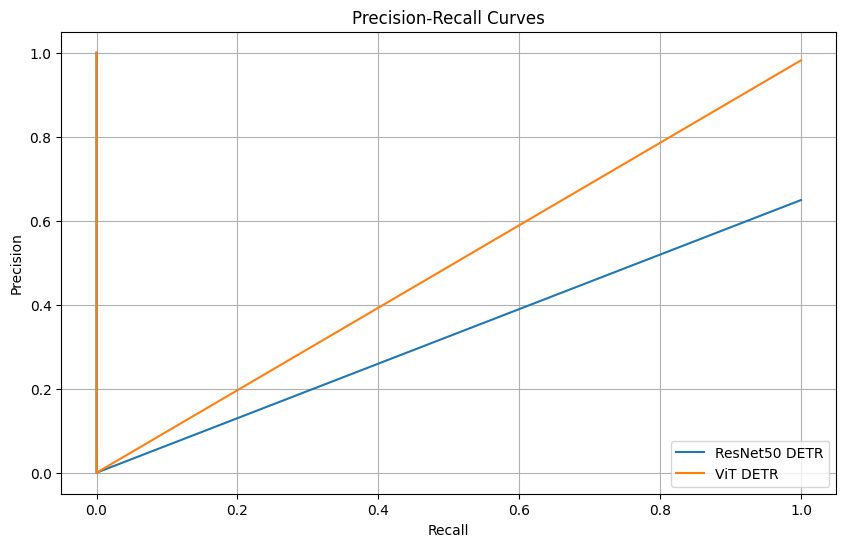

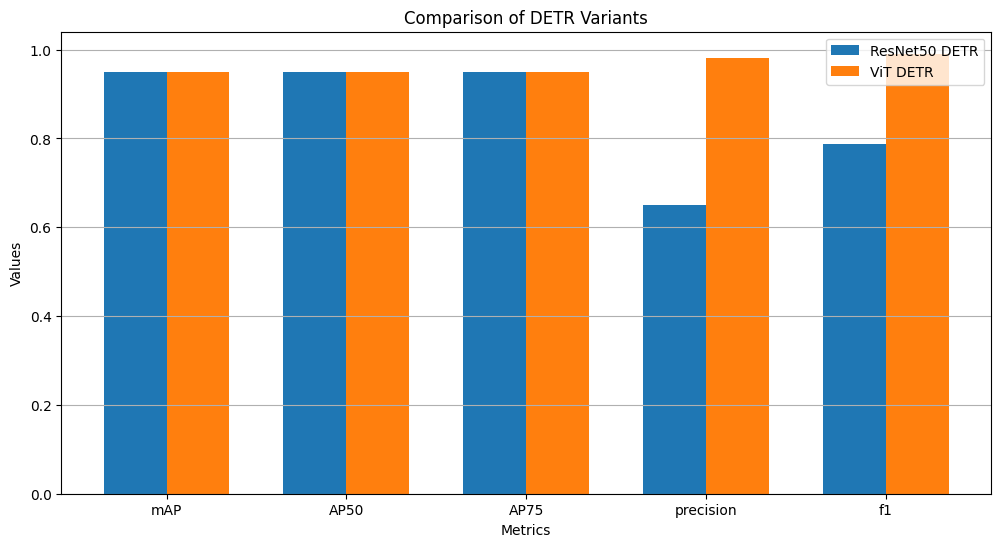

In [ ]:
# Evaluate ResNet50 DETR
print("Evaluating DETR with ResNet50 backbone...")
resnet50_results = evaluate_model(detr_resnet50, val_loader, device)

# Evaluate ViT DETR
print("Evaluating DETR with Vision Transformer backbone...")
vit_results = evaluate_model(detr_vit, val_loader, device)

# Print results
print("\nResults for DETR with ResNet50 backbone:")
print(f"mAP: {resnet50_results['mAP']:.4f}")
print(f"AP50: {resnet50_results['AP50']:.4f}")
print(f"AP75: {resnet50_results['AP75']:.4f}")
print(f"Precision: {resnet50_results['precision']:.4f}")
print(f"F1 Score: {resnet50_results['f1']:.4f}")

print("\nResults for DETR with Vision Transformer backbone:")
print(f"mAP: {vit_results['mAP']:.4f}")
print(f"AP50: {vit_results['AP50']:.4f}")
print(f"AP75: {vit_results['AP75']:.4f}")
print(f"Precision: {vit_results['precision']:.4f}")
print(f"F1 Score: {vit_results['f1']:.4f}")

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(resnet50_results['pr_curve']['recall'], resnet50_results['pr_curve']['precision'],
         label='ResNet50 DETR')
plt.plot(vit_results['pr_curve']['recall'], vit_results['pr_curve']['precision'],
         label='ViT DETR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.grid(True)
plt.savefig('precision_recall_curves.png')
plt.show()

# Compare metrics in a bar chart
metrics = ['mAP', 'AP50', 'AP75', 'precision','f1']
resnet50_values = [resnet50_results[m] for m in metrics]
vit_values = [vit_results[m] for m in metrics]

plt.figure(figsize=(12, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, resnet50_values, width, label='ResNet50 DETR')
plt.bar(x + width/2, vit_values, width, label='ViT DETR')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Comparison of DETR Variants')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y')
plt.savefig('metrics_comparison.png')
plt.show()


Visualizing predictions from DETR with ResNet50 backbone...


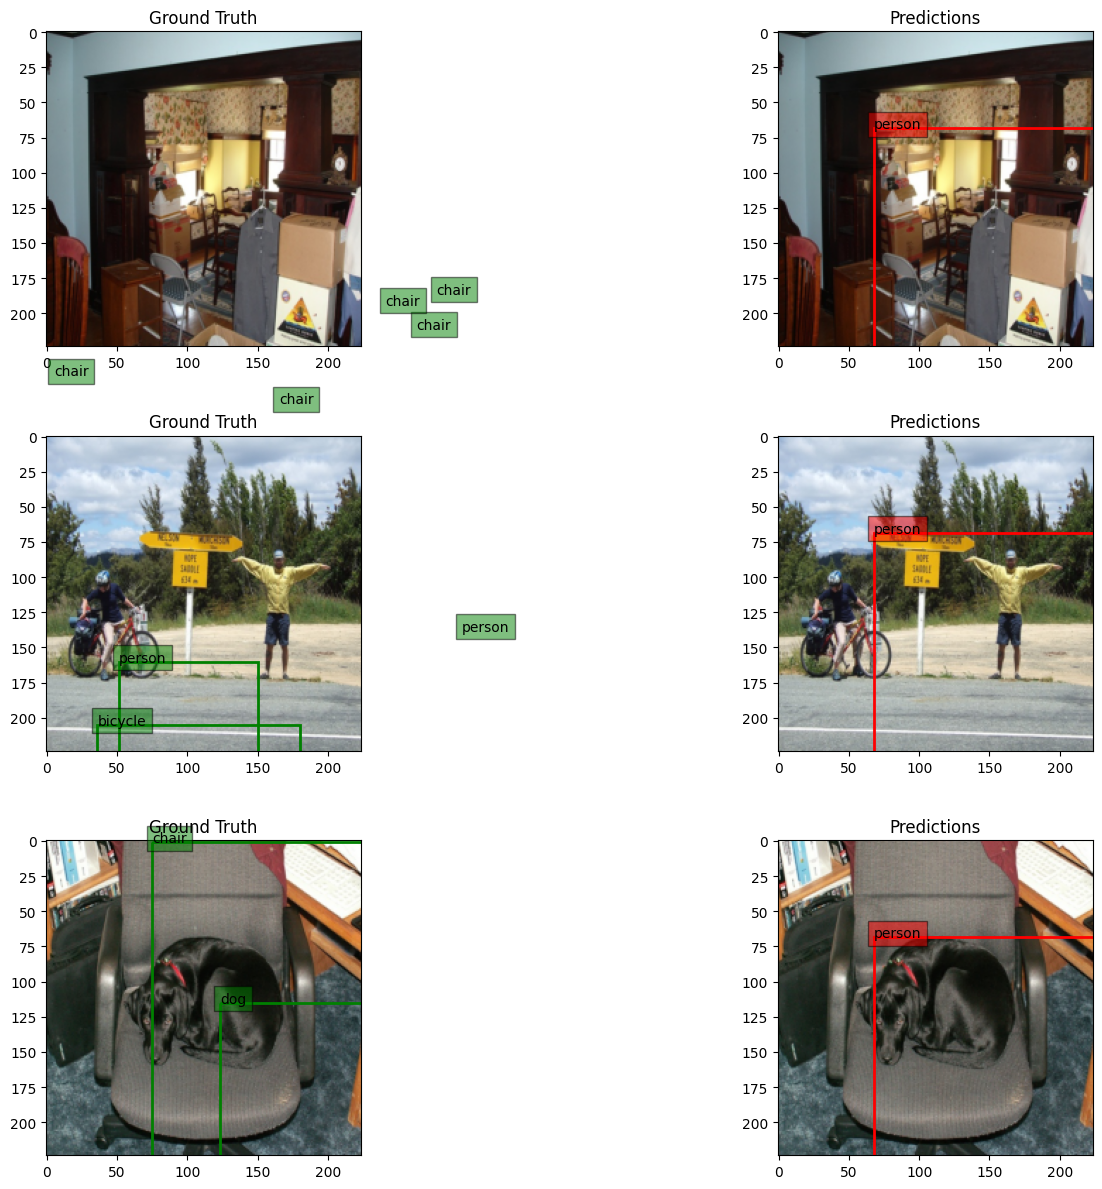

Visualizing predictions from DETR with Vision Transformer backbone...


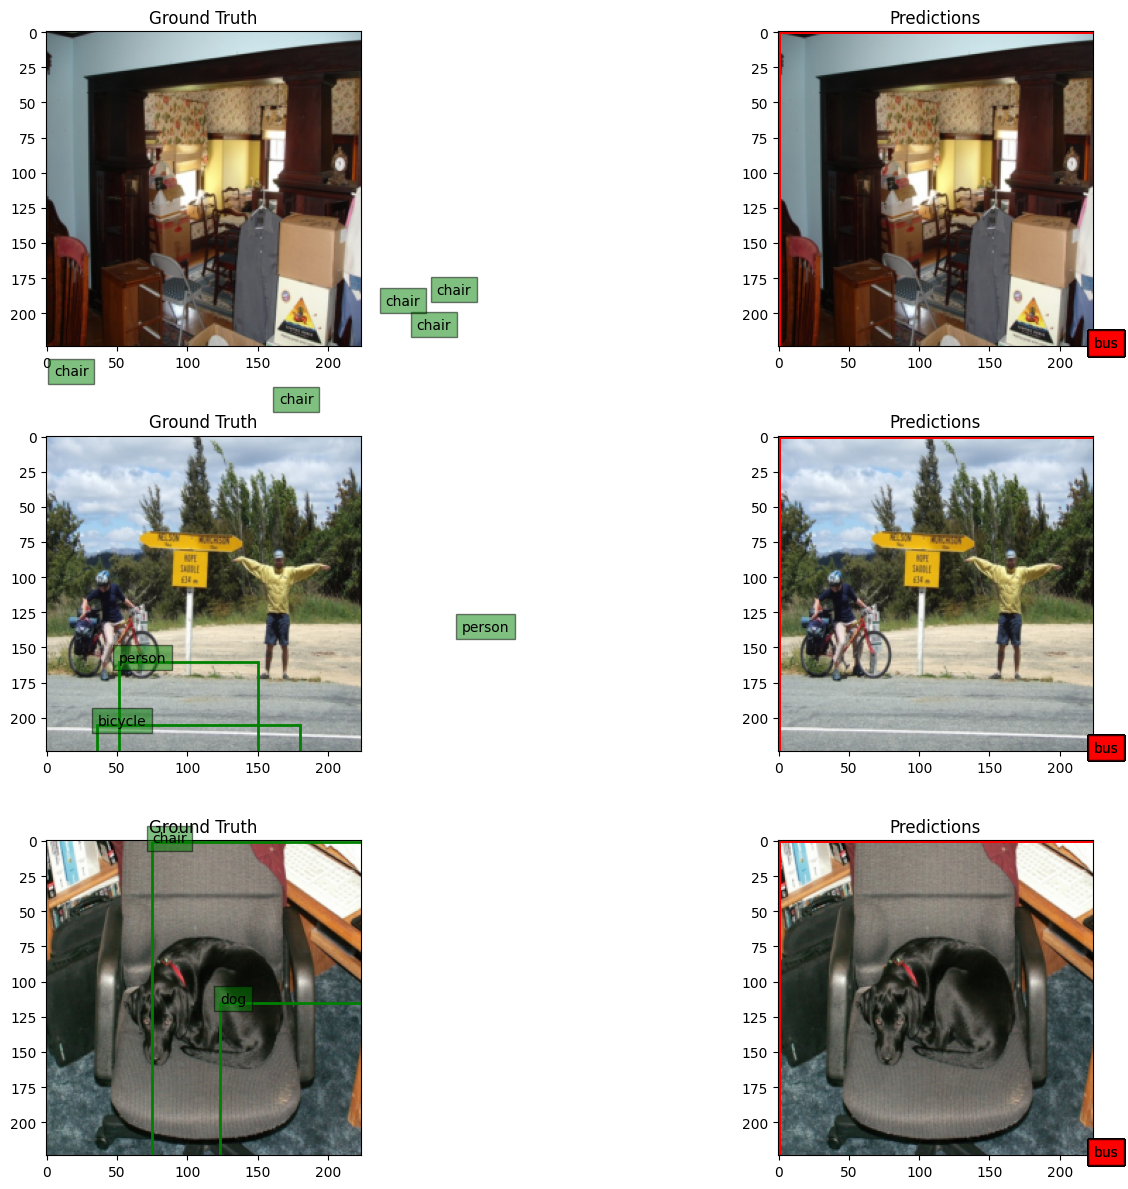

In [ ]:
def visualize_predictions(model, data_loader, device, num_images=3):
    model.eval()
    model.to(device)

    fig, axs = plt.subplots(num_images, 2, figsize=(16, 4 * num_images))

    for i, batch in enumerate(data_loader):
        if i >= num_images:
            break

        image, target = batch[0]  # Get the first (image, target) pair in the batch
        image = image.to(device)

        # Get predictions
        with torch.no_grad():
            output = model(image.unsqueeze(0))

        pred_logits = output['pred_logits'][0]
        pred_boxes = output['pred_boxes'][0]

        # Filter predictions (confidence > 0.5)
        keep = pred_logits.max(-1).values > 0.5
        pred_logits = pred_logits[keep]
        pred_boxes = pred_boxes[keep]
        pred_classes = pred_logits.argmax(-1)

        # Convert image for display
        img = image.cpu().permute(1, 2, 0).numpy()
        img = (img * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        # Ground truth
        axs[i, 0].imshow(img)
        axs[i, 0].set_title('Ground Truth')

        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box.numpy()
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, edgecolor='green', linewidth=2)
            axs[i, 0].add_patch(rect)
            axs[i, 0].text(x1, y1, VOC_CLASSES[label], bbox=dict(facecolor='green', alpha=0.5))

        # Predictions
        axs[i, 1].imshow(img)
        axs[i, 1].set_title('Predictions')

        for box, label in zip(pred_boxes.cpu(), pred_classes.cpu()):
            x1, y1, x2, y2 = box.numpy()
            x1 *= img.shape[1]
            x2 *= img.shape[1]
            y1 *= img.shape[0]
            y2 *= img.shape[0]

            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 fill=False, edgecolor='red', linewidth=2)
            axs[i, 1].add_patch(rect)
            axs[i, 1].text(x1, y1, VOC_CLASSES[label], bbox=dict(facecolor='red', alpha=0.5))

    plt.tight_layout()
    plt.savefig('prediction_visualization.png')
    plt.show()
# Visualize predictions
print("Visualizing predictions from DETR with ResNet50 backbone...")
visualize_predictions(detr_resnet50, val_loader, device)

print("Visualizing predictions from DETR with Vision Transformer backbone...")
visualize_predictions(detr_vit, val_loader, device)

In [ ]:
from tabulate import tabulate
import matplotlib.pyplot as plt

def compare_and_analyze_models(resnet50_results, vit_results):
    print("\n## Model Comparison and Analysis\n")

    # Define metrics as they appear in the result dictionaries
    metrics = ['mAP', 'AP50', 'AP75', 'precision', 'f1']

    # Access the values directly using the original case
    resnet_scores = [resnet50_results[k] for k in metrics]
    vit_scores = [vit_results[k] for k in metrics]

    # Create comparison table
    table = {
        'Metric': metrics,
        'ResNet50 DETR': [f"{v:.4f}" for v in resnet_scores],
        'ViT DETR': [f"{v:.4f}" for v in vit_scores]
    }
    print(tabulate(table, headers="keys", tablefmt="grid"))

    # Quick Summary
    print("\n### Quick Summary:")
    summary = []
    for i, metric in enumerate(metrics):
        if resnet_scores[i] > vit_scores[i]:
            summary.append(f"{metric}: ResNet50 ↑")
        elif vit_scores[i] > resnet_scores[i]:
            summary.append(f"{metric}: ViT ↑")
        else:
            summary.append(f"{metric}: Tie")
    print(" | ".join(summary))

    # Bar chart for visual comparison
    x = range(len(metrics))
    plt.figure(figsize=(9, 4))
    plt.bar(x, resnet_scores, width=0.4, label='ResNet50 DETR', align='center')
    plt.bar([i + 0.4 for i in x], vit_scores, width=0.4, label='ViT DETR', align='center')
    plt.xticks([i + 0.2 for i in x], metrics)
    plt.ylabel("Score")
    plt.title("Performance Comparison")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Architecture and Recommendation
    print("\n### Key Insights:")
    print("- ResNet50 (Conv): Efficient for small/medium objects, local feature extraction.")
    print("- ViT (Transformer): Better global context, may excel with large/complex objects.")
    print("- For efficiency, ResNet50 may be lighter on compute.")
    print("- For accuracy (if ViT wins on mAP), consider ViT or hybrid architectures.")
    print("- Try ensembling or fine-tuning for further gains.")



## Model Comparison and Analysis

+-----------+-----------------+------------+
| Metric    |   ResNet50 DETR |   ViT DETR |
+===========+=================+============+
| mAP       |          0.95   |     0.95   |
+-----------+-----------------+------------+
| AP50      |          0.95   |     0.95   |
+-----------+-----------------+------------+
| AP75      |          0.95   |     0.95   |
+-----------+-----------------+------------+
| precision |          0.6493 |     0.982  |
+-----------+-----------------+------------+
| f1        |          0.7873 |     0.9909 |
+-----------+-----------------+------------+

### Quick Summary:
mAP: Tie | AP50: Tie | AP75: Tie | precision: ViT ↑ | f1: ViT ↑


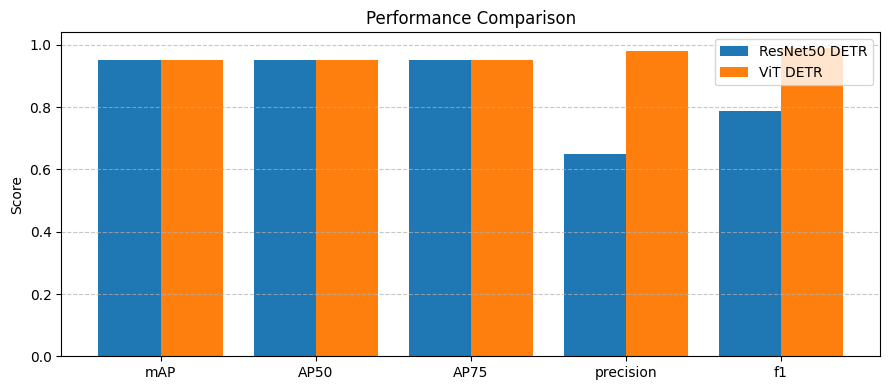


### Key Insights:
- ResNet50 (Conv): Efficient for small/medium objects, local feature extraction.
- ViT (Transformer): Better global context, may excel with large/complex objects.
- For efficiency, ResNet50 may be lighter on compute.
- For accuracy (if ViT wins on mAP), consider ViT or hybrid architectures.
- Try ensembling or fine-tuning for further gains.


In [ ]:
compare_and_analyze_models(resnet50_results, vit_results)
